# Multi-Asset Portfolio Analysis - Daily Rebalanced Equal Weight Portfolio

This notebook combines the **optimized** commodities and forex contrarian strategies into a single daily-rebalanced equal-weighted portfolio.

**Strategy Components:**
- **Commodities**: **OPTIMIZED** configuration from COMMODITIES_OPT.ipynb analysis:
  - 60 days lookback for rolling drawdown filter
  - 8% drawdown threshold 
  - 1.0x leverage
  - **102.40% total return (BEST)**
- **Forex**: Risk parity optimized portfolio (already optimized)
- **Rebalancing**: Daily equal-weighted (50/50) allocation without lookahead bias

**Key Features:**
- Daily rebalancing between **OPTIMIZED** commodities and forex strategies  
- Proper lookahead bias prevention using `.shift(1)` for all decisions
- Uses the **BEST** configuration from commodities optimization analysis
- Performance comparison and diversification analysis
- Comprehensive visualization of combined vs individual optimized strategies

**Expected Performance:**
- Commodities optimized strategy: ~102% total return with 8% threshold filtering
- Forex risk parity: Already optimized through inverse volatility weighting
- Combined portfolio: Expected diversification benefits through daily rebalancing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import warnings
import seaborn as sns
from datetime import datetime

warnings.filterwarnings('ignore')

# Set plotting parameters
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.formatter.limits'] = [-3, 3]
sns.set_style("whitegrid")

print("📊 MULTI-ASSET PORTFOLIO ANALYSIS - DAILY REBALANCED EQUAL WEIGHT")
print("=" * 80)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Combining optimized Commodities and Forex contrarian strategies")

📊 MULTI-ASSET PORTFOLIO ANALYSIS - DAILY REBALANCED EQUAL WEIGHT
Analysis Date: 2025-08-09 19:29:29
Combining optimized Commodities and Forex contrarian strategies


## 1. Data Loading and Preparation

Load the optimized equity curves from both strategies:

In [2]:
def load_strategy_data():
    """
    Load optimized equity curves from both commodities and forex strategies
    """
    print("📈 Loading strategy data...")
    
    # Load commodities data - using OPTIMIZED configuration from COMMODITIES_OPT.ipynb
    commodities_data_path = Path('../commodities/data/results')
    
    # Load the base equal weight commodities portfolio
    commodities_equity = pd.read_parquet(commodities_data_path / 'all_equity_curves.parquet')
    
    # Calculate commodities equal weight portfolio (base before optimization)
    commodities_prices = 1 + commodities_equity  # Convert from cumulative returns to prices
    commodities_daily_returns = commodities_prices.pct_change().fillna(0)
    commodities_base_returns = commodities_daily_returns.mean(axis=1)
    commodities_base_equity = (1 + commodities_base_returns).cumprod()
    
    print(f"   • Commodities: {commodities_equity.shape[1]} strategies, {len(commodities_equity)} days")
    print(f"   • Date range: {commodities_equity.index.min().strftime('%Y-%m-%d')} to {commodities_equity.index.max().strftime('%Y-%m-%d')}")
    
    # APPLY OPTIMAL PARAMETERS from COMMODITIES_OPT.ipynb analysis
    # Best combination: 60 days lookback, 8% threshold, 1.0x leverage
    print("   • Applying OPTIMAL parameters: 60d lookback, 8% threshold, 1.0x leverage")
    
    # Import drawdown filter
    import sys
    sys.path.append('../commodities/')
    from drawdown_filter import apply_drawdown_filter
    
    # Apply optimal drawdown filter to commodities base portfolio
    optimal_lookback = 60  # days
    optimal_threshold = 0.08  # 8%
    optimal_leverage = 1.0  # 1.0x
    
    # Apply leverage first (though 1.0x means no change)
    leveraged_returns = commodities_base_returns * optimal_leverage
    leveraged_equity = (1 + leveraged_returns).cumprod()
    
    # Apply drawdown filter
    filter_df = apply_drawdown_filter(
        leveraged_equity, 
        leveraged_returns,
        optimal_lookback,
        optimal_threshold
    )
    
    # Use the FILTERED and OPTIMIZED equity curve
    commodities_strategy_equity = filter_df['filtered_equity'].copy()
    
    # Calculate filter statistics
    filter_active_time = (filter_df['can_trade_lagged'].sum() / len(filter_df)) * 100
    final_return = (commodities_strategy_equity.iloc[-1] / commodities_strategy_equity.iloc[0] - 1) * 100
    
    print(f"   • Commodities OPTIMIZED: {final_return:.2f}% total return")
    print(f"   • Filter active: {filter_active_time:.1f}% of time")
    
    # Load forex data - using the risk parity optimized portfolio
    forex_data_path = Path('../forex/data/results')
    
    # Load the forex risk parity portfolio (already optimized)
    forex_portfolio = pd.read_parquet(forex_data_path / 'risk_parity_portfolio.parquet')
    forex_strategy_equity = forex_portfolio['equity'].copy()
    
    forex_return = (forex_strategy_equity.iloc[-1] / forex_strategy_equity.iloc[0] - 1) * 100
    print(f"   • Forex: Risk parity portfolio, {len(forex_strategy_equity)} days")
    print(f"   • Forex total return: {forex_return:.2f}%")
    print(f"   • Date range: {forex_strategy_equity.index.min().strftime('%Y-%m-%d')} to {forex_strategy_equity.index.max().strftime('%Y-%m-%d')}")
    
    return commodities_strategy_equity, forex_strategy_equity

def align_strategies(commodities_equity, forex_equity):
    """
    Align both strategies to common date range and handle missing data
    """
    print("🔄 Aligning strategy dates...")
    
    # Find common date range
    common_start = max(commodities_equity.index.min(), forex_equity.index.min())
    common_end = min(commodities_equity.index.max(), forex_equity.index.max())
    
    print(f"   • Common date range: {common_start.strftime('%Y-%m-%d')} to {common_end.strftime('%Y-%m-%d')}")
    
    # Align both series to common dates
    commodities_aligned = commodities_equity.loc[common_start:common_end]
    forex_aligned = forex_equity.loc[common_start:common_end]
    
    # Create combined DataFrame
    aligned_data = pd.DataFrame({
        'commodities_equity': commodities_aligned,
        'forex_equity': forex_aligned
    })
    
    # Forward fill any missing values
    aligned_data = aligned_data.fillna(method='ffill')
    
    # Remove any remaining NaN values
    aligned_data = aligned_data.dropna()
    
    print(f"   • Aligned data: {len(aligned_data)} trading days")
    print(f"   • Missing data points: {aligned_data.isnull().sum().sum()}")
    
    return aligned_data

# Load and align the data
commodities_equity, forex_equity = load_strategy_data()
aligned_strategies = align_strategies(commodities_equity, forex_equity)

print("\n✅ Data loading and alignment completed")

📈 Loading strategy data...
   • Commodities: 15 strategies, 5696 days
   • Date range: 2010-01-04 to 2025-08-08
   • Applying OPTIMAL parameters: 60d lookback, 8% threshold, 1.0x leverage
   • Commodities OPTIMIZED: 102.40% total return
   • Filter active: 98.0% of time
   • Forex: Risk parity portfolio, 5697 days
   • Forex total return: 22.28%
   • Date range: 2010-01-01 to 2025-08-06
🔄 Aligning strategy dates...
   • Common date range: 2010-01-04 to 2025-08-06
   • Aligned data: 5694 trading days
   • Missing data points: 0

✅ Data loading and alignment completed


## 2. Daily Equal-Weighted Rebalancing Implementation

Implement the daily rebalancing logic without lookahead bias:

In [3]:
def calculate_daily_rebalanced_portfolio(strategy_data, equal_weight=True):
    """
    Calculate daily rebalanced portfolio returns without lookahead bias
    
    Parameters:
    - strategy_data: DataFrame with equity curves for each strategy
    - equal_weight: If True, use 50/50 weights, otherwise use dynamic weighting
    """
    print("⚖️  Calculating daily rebalanced portfolio...")
    
    # Calculate daily returns for each strategy
    daily_returns = strategy_data.pct_change().fillna(0)
    daily_returns.columns = ['commodities_returns', 'forex_returns']
    
    if equal_weight:
        # Equal weight portfolio: 50% commodities, 50% forex
        weights = pd.DataFrame({
            'commodities_weight': 0.5,
            'forex_weight': 0.5
        }, index=daily_returns.index)
        
        print("   • Using equal weights: 50% Commodities, 50% Forex")
    else:
        # Could implement dynamic weighting here (e.g., inverse volatility)
        # For now, we'll stick with equal weighting
        weights = pd.DataFrame({
            'commodities_weight': 0.5,
            'forex_weight': 0.5
        }, index=daily_returns.index)
    
    # Apply lookahead bias prevention: weights based on previous day's information
    # This ensures rebalancing decisions are made with information available at time t-1
    weights_lagged = weights.shift(1)
    
    # Fill first day with initial weights
    weights_lagged.iloc[0] = weights.iloc[0]
    
    # Calculate portfolio daily returns
    portfolio_returns = (
        weights_lagged['commodities_weight'] * daily_returns['commodities_returns'] +
        weights_lagged['forex_weight'] * daily_returns['forex_returns']
    )
    
    # Calculate cumulative equity curve
    portfolio_equity = (1 + portfolio_returns).cumprod()
    
    # Create comprehensive results DataFrame
    results = pd.DataFrame({
        'commodities_equity': strategy_data['commodities_equity'],
        'forex_equity': strategy_data['forex_equity'],
        'commodities_returns': daily_returns['commodities_returns'],
        'forex_returns': daily_returns['forex_returns'],
        'commodities_weight': weights_lagged['commodities_weight'],
        'forex_weight': weights_lagged['forex_weight'],
        'portfolio_returns': portfolio_returns,
        'portfolio_equity': portfolio_equity
    })
    
    return results

def calculate_performance_metrics(equity_series, returns_series, name="Portfolio"):
    """
    Calculate comprehensive performance metrics
    """
    if len(returns_series) == 0 or equity_series.empty:
        return None
    
    # Basic metrics
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0] - 1) * 100
    
    # Annualized metrics
    trading_days = len(returns_series)
    years = trading_days / 252
    
    if years > 0:
        cagr = ((equity_series.iloc[-1] / equity_series.iloc[0]) ** (1/years) - 1) * 100
    else:
        cagr = 0
    
    annual_return = returns_series.mean() * 252 * 100
    annual_volatility = returns_series.std() * np.sqrt(252) * 100
    
    # Sharpe ratio
    if annual_volatility > 0:
        sharpe_ratio = annual_return / annual_volatility
    else:
        sharpe_ratio = 0
    
    # Drawdown metrics
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    avg_drawdown = drawdown.mean() * 100
    
    # Calmar ratio
    if max_drawdown < 0:
        calmar_ratio = cagr / abs(max_drawdown)
    else:
        calmar_ratio = 0
    
    return {
        'Strategy': name,
        'Total Return (%)': total_return,
        'CAGR (%)': cagr,
        'Annual Return (%)': annual_return,
        'Annual Volatility (%)': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Avg Drawdown (%)': avg_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Trading Days': trading_days
    }

# Calculate the rebalanced portfolio
portfolio_results = calculate_daily_rebalanced_portfolio(aligned_strategies)

print(f"\n📊 Portfolio calculation completed:")
print(f"   • Final portfolio value: {portfolio_results['portfolio_equity'].iloc[-1]:.4f}")
print(f"   • Total portfolio return: {(portfolio_results['portfolio_equity'].iloc[-1] - 1) * 100:.2f}%")
print(f"   • Trading period: {len(portfolio_results)} days")

⚖️  Calculating daily rebalanced portfolio...
   • Using equal weights: 50% Commodities, 50% Forex

📊 Portfolio calculation completed:
   • Final portfolio value: 1.5935
   • Total portfolio return: 59.35%
   • Trading period: 5694 days


## 3. Performance Analysis and Comparison

Calculate and compare performance metrics:

In [4]:
# Calculate performance metrics for all strategies
print("📈 PERFORMANCE ANALYSIS")
print("=" * 50)

# Individual strategy metrics
commodities_metrics = calculate_performance_metrics(
    portfolio_results['commodities_equity'],
    portfolio_results['commodities_returns'],
    "Commodities Strategy"
)

forex_metrics = calculate_performance_metrics(
    portfolio_results['forex_equity'],
    portfolio_results['forex_returns'],
    "Forex Strategy"
)

# Combined portfolio metrics
portfolio_metrics = calculate_performance_metrics(
    portfolio_results['portfolio_equity'],
    portfolio_results['portfolio_returns'],
    "Combined Portfolio"
)

# Create comparison DataFrame
comparison_df = pd.DataFrame([commodities_metrics, forex_metrics, portfolio_metrics])

print("\n📊 PERFORMANCE COMPARISON TABLE:")
print("=" * 80)
print(comparison_df.round(3).to_string(index=False))

# Calculate diversification benefits
print("\n🎯 DIVERSIFICATION ANALYSIS:")
print("=" * 40)

# Correlation analysis
correlation = portfolio_results['commodities_returns'].corr(portfolio_results['forex_returns'])
print(f"   • Daily returns correlation: {correlation:.4f}")

# Portfolio vs individual strategy comparison
commodities_sharpe = commodities_metrics['Sharpe Ratio']
forex_sharpe = forex_metrics['Sharpe Ratio']
portfolio_sharpe = portfolio_metrics['Sharpe Ratio']

print(f"   • Commodities Sharpe: {commodities_sharpe:.4f}")
print(f"   • Forex Sharpe: {forex_sharpe:.4f}")
print(f"   • Portfolio Sharpe: {portfolio_sharpe:.4f}")

# Sharpe improvement
best_individual_sharpe = max(commodities_sharpe, forex_sharpe)
sharpe_improvement = portfolio_sharpe - best_individual_sharpe
print(f"   • Sharpe improvement: {sharpe_improvement:+.4f}")

# Volatility reduction
commodities_vol = commodities_metrics['Annual Volatility (%)']
forex_vol = forex_metrics['Annual Volatility (%)']
portfolio_vol = portfolio_metrics['Annual Volatility (%)']

avg_individual_vol = (commodities_vol + forex_vol) / 2
vol_reduction = avg_individual_vol - portfolio_vol
print(f"   • Average individual volatility: {avg_individual_vol:.2f}%")
print(f"   • Portfolio volatility: {portfolio_vol:.2f}%")
print(f"   • Volatility reduction: {vol_reduction:+.2f}%")

# Maximum drawdown comparison
commodities_dd = commodities_metrics['Max Drawdown (%)']
forex_dd = forex_metrics['Max Drawdown (%)']
portfolio_dd = portfolio_metrics['Max Drawdown (%)']

worst_individual_dd = min(commodities_dd, forex_dd)  # More negative is worse
dd_improvement = portfolio_dd - worst_individual_dd
print(f"   • Worst individual max DD: {worst_individual_dd:.2f}%")
print(f"   • Portfolio max DD: {portfolio_dd:.2f}%")
print(f"   • Drawdown improvement: {dd_improvement:+.2f}%")

📈 PERFORMANCE ANALYSIS

📊 PERFORMANCE COMPARISON TABLE:
            Strategy  Total Return (%)  CAGR (%)  Annual Return (%)  Annual Volatility (%)  Sharpe Ratio  Max Drawdown (%)  Avg Drawdown (%)  Calmar Ratio  Trading Days
Commodities Strategy           101.734     3.155              3.340                  6.833         0.489           -18.459            -6.024         0.171          5694
      Forex Strategy            22.275     0.894              0.917                  2.329         0.394            -9.661            -2.549         0.093          5694
  Combined Portfolio            59.347     2.083              2.128                  3.641         0.585            -9.037            -2.654         0.231          5694

🎯 DIVERSIFICATION ANALYSIS:
   • Daily returns correlation: 0.0290
   • Commodities Sharpe: 0.4888
   • Forex Sharpe: 0.3938
   • Portfolio Sharpe: 0.5845
   • Sharpe improvement: +0.0958
   • Average individual volatility: 4.58%
   • Portfolio volatility: 3.64%
   •

## 4. Equity Curves Visualization

Comprehensive visualization of all strategies:

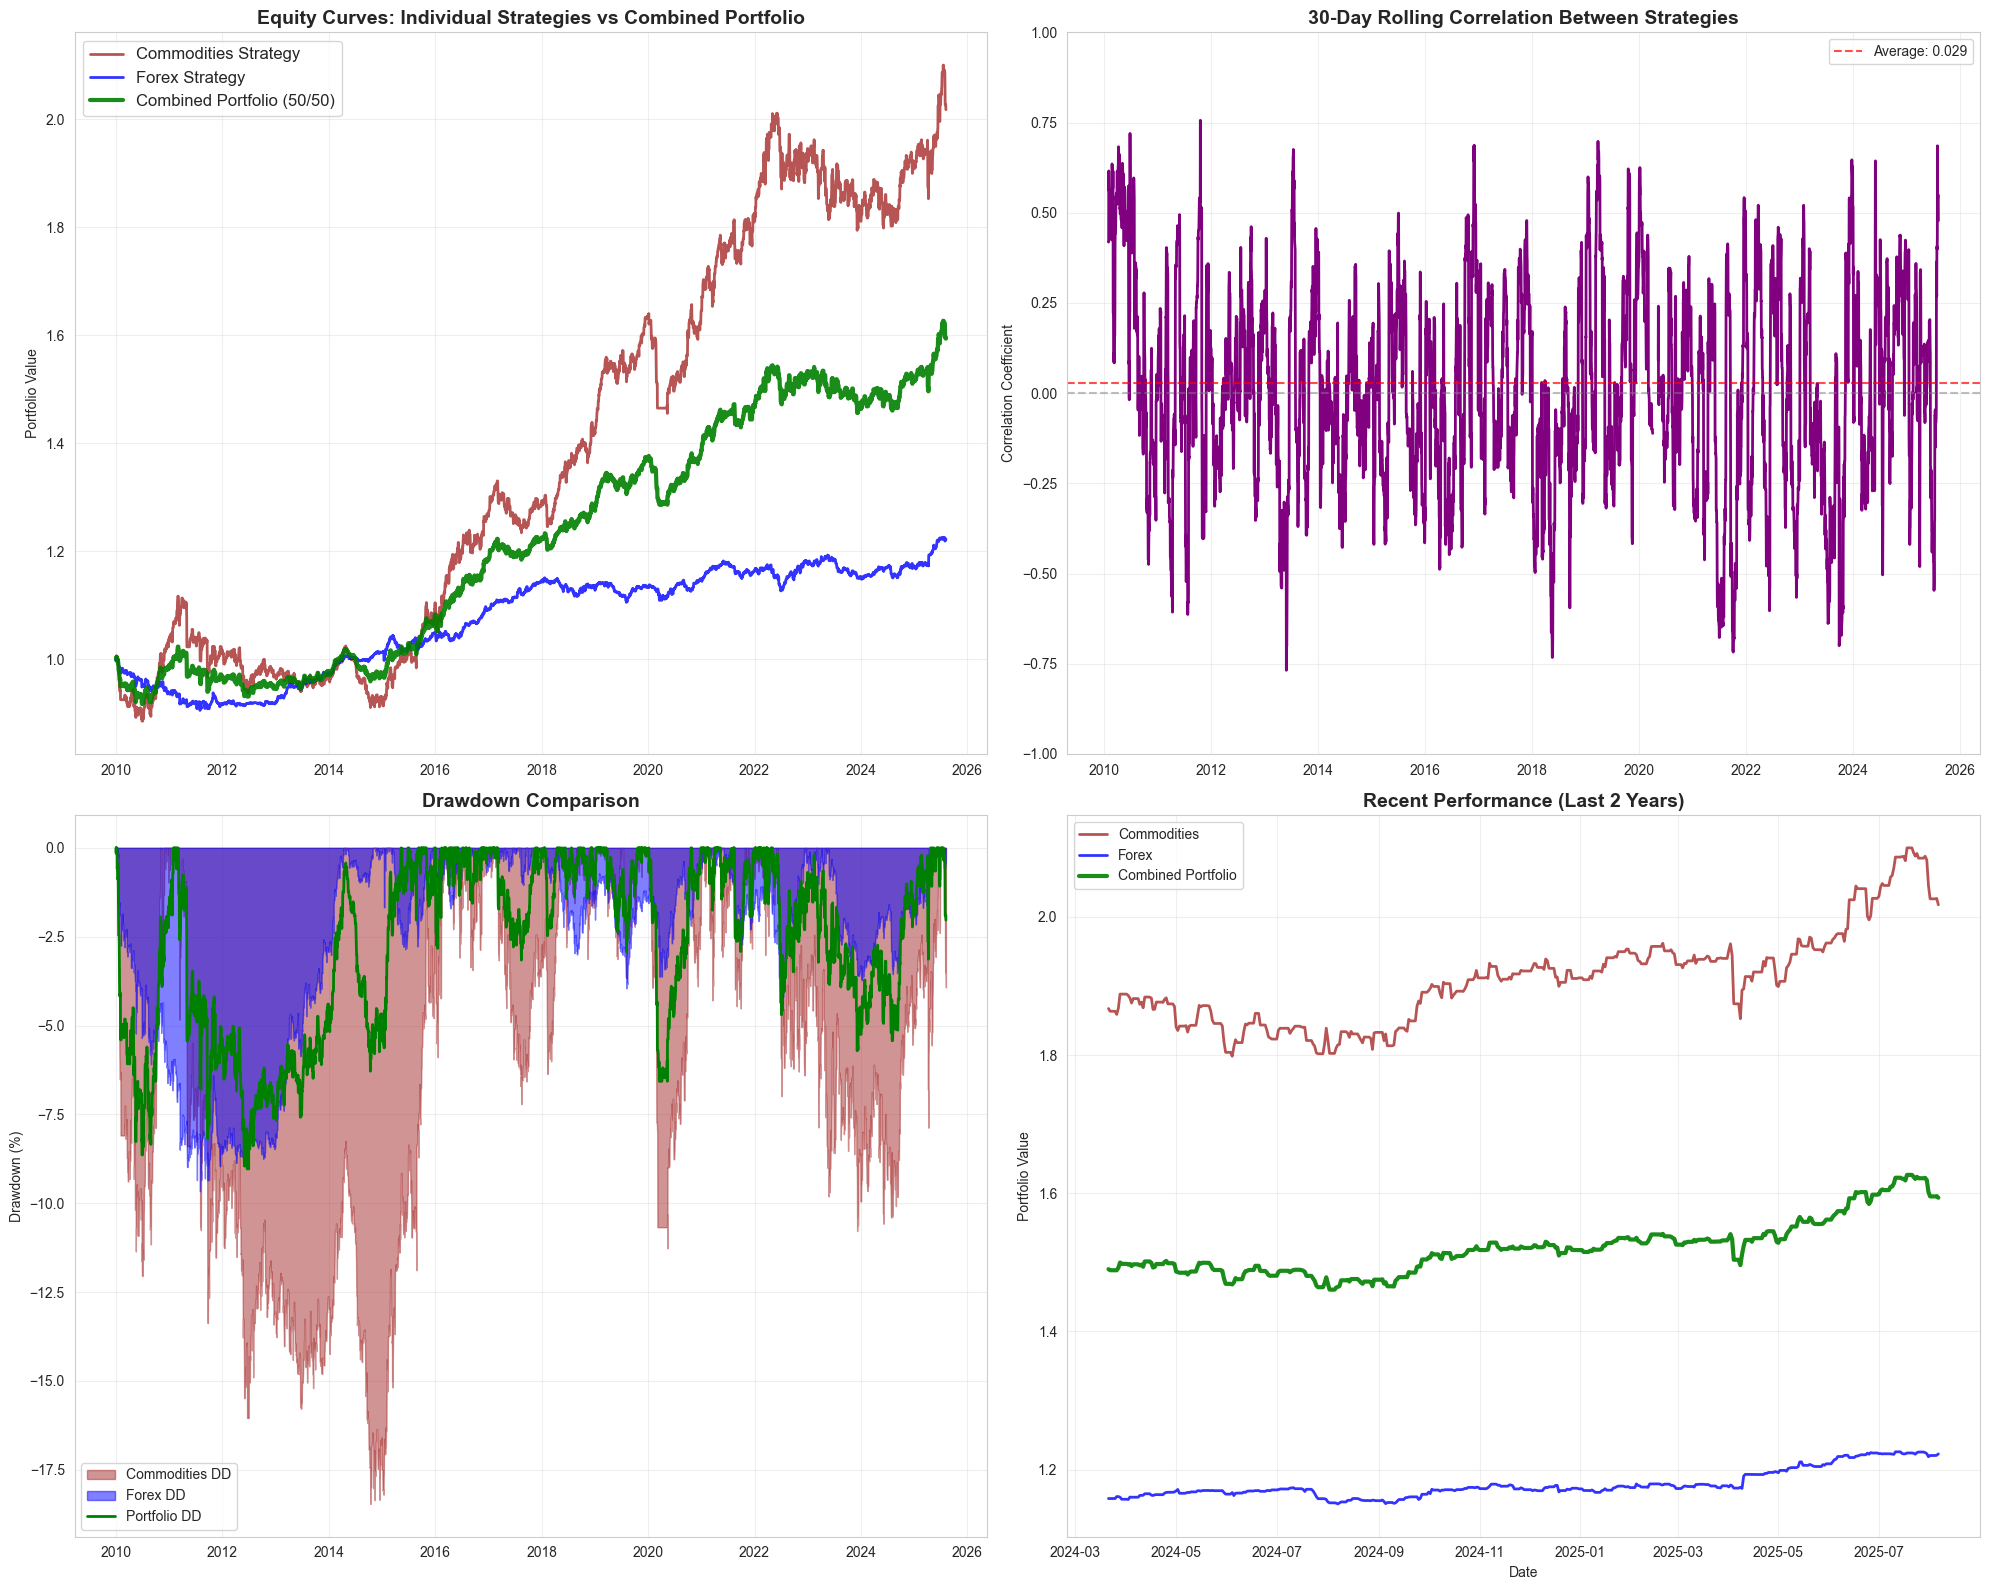

✅ Equity curve visualizations completed


In [5]:
# Create comprehensive equity curve plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: All equity curves comparison
ax1 = axes[0, 0]
ax1.plot(portfolio_results.index, portfolio_results['commodities_equity'], 
         label='Commodities Strategy', linewidth=2, color='brown', alpha=0.8)
ax1.plot(portfolio_results.index, portfolio_results['forex_equity'], 
         label='Forex Strategy', linewidth=2, color='blue', alpha=0.8)
ax1.plot(portfolio_results.index, portfolio_results['portfolio_equity'], 
         label='Combined Portfolio (50/50)', linewidth=3, color='green', alpha=0.9)

ax1.set_title('Equity Curves: Individual Strategies vs Combined Portfolio', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling correlation (30-day window)
ax2 = axes[0, 1]
rolling_corr = portfolio_results['commodities_returns'].rolling(30).corr(
    portfolio_results['forex_returns']
)
ax2.plot(rolling_corr.index, rolling_corr.values, color='purple', linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=correlation, color='red', linestyle='--', alpha=0.7, 
           label=f'Average: {correlation:.3f}')

ax2.set_title('30-Day Rolling Correlation Between Strategies', fontsize=14, fontweight='bold')
ax2.set_ylabel('Correlation Coefficient')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-1, 1)

# Plot 3: Drawdown comparison
ax3 = axes[1, 0]

# Calculate drawdowns
def calculate_drawdown_series(equity):
    peak = equity.expanding().max()
    drawdown = (equity - peak) / peak
    return drawdown * 100

commodities_dd = calculate_drawdown_series(portfolio_results['commodities_equity'])
forex_dd = calculate_drawdown_series(portfolio_results['forex_equity'])
portfolio_dd = calculate_drawdown_series(portfolio_results['portfolio_equity'])

ax3.fill_between(portfolio_results.index, commodities_dd, 0, 
                alpha=0.5, color='brown', label='Commodities DD')
ax3.fill_between(portfolio_results.index, forex_dd, 0, 
                alpha=0.5, color='blue', label='Forex DD')
ax3.plot(portfolio_results.index, portfolio_dd, 
         color='green', linewidth=2, label='Portfolio DD')

ax3.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Drawdown (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Recent performance (last 2 years)
ax4 = axes[1, 1]
recent_data = portfolio_results.iloc[-504:] if len(portfolio_results) > 504 else portfolio_results

ax4.plot(recent_data.index, recent_data['commodities_equity'], 
         label='Commodities', linewidth=2, color='brown', alpha=0.8)
ax4.plot(recent_data.index, recent_data['forex_equity'], 
         label='Forex', linewidth=2, color='blue', alpha=0.8)
ax4.plot(recent_data.index, recent_data['portfolio_equity'], 
         label='Combined Portfolio', linewidth=3, color='green', alpha=0.9)

ax4.set_title('Recent Performance (Last 2 Years)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Portfolio Value')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Equity curve visualizations completed")

## 5. Rolling Performance Analysis

Analyze rolling performance metrics to assess stability:

📊 ROLLING PERFORMANCE ANALYSIS (12-Month Windows)


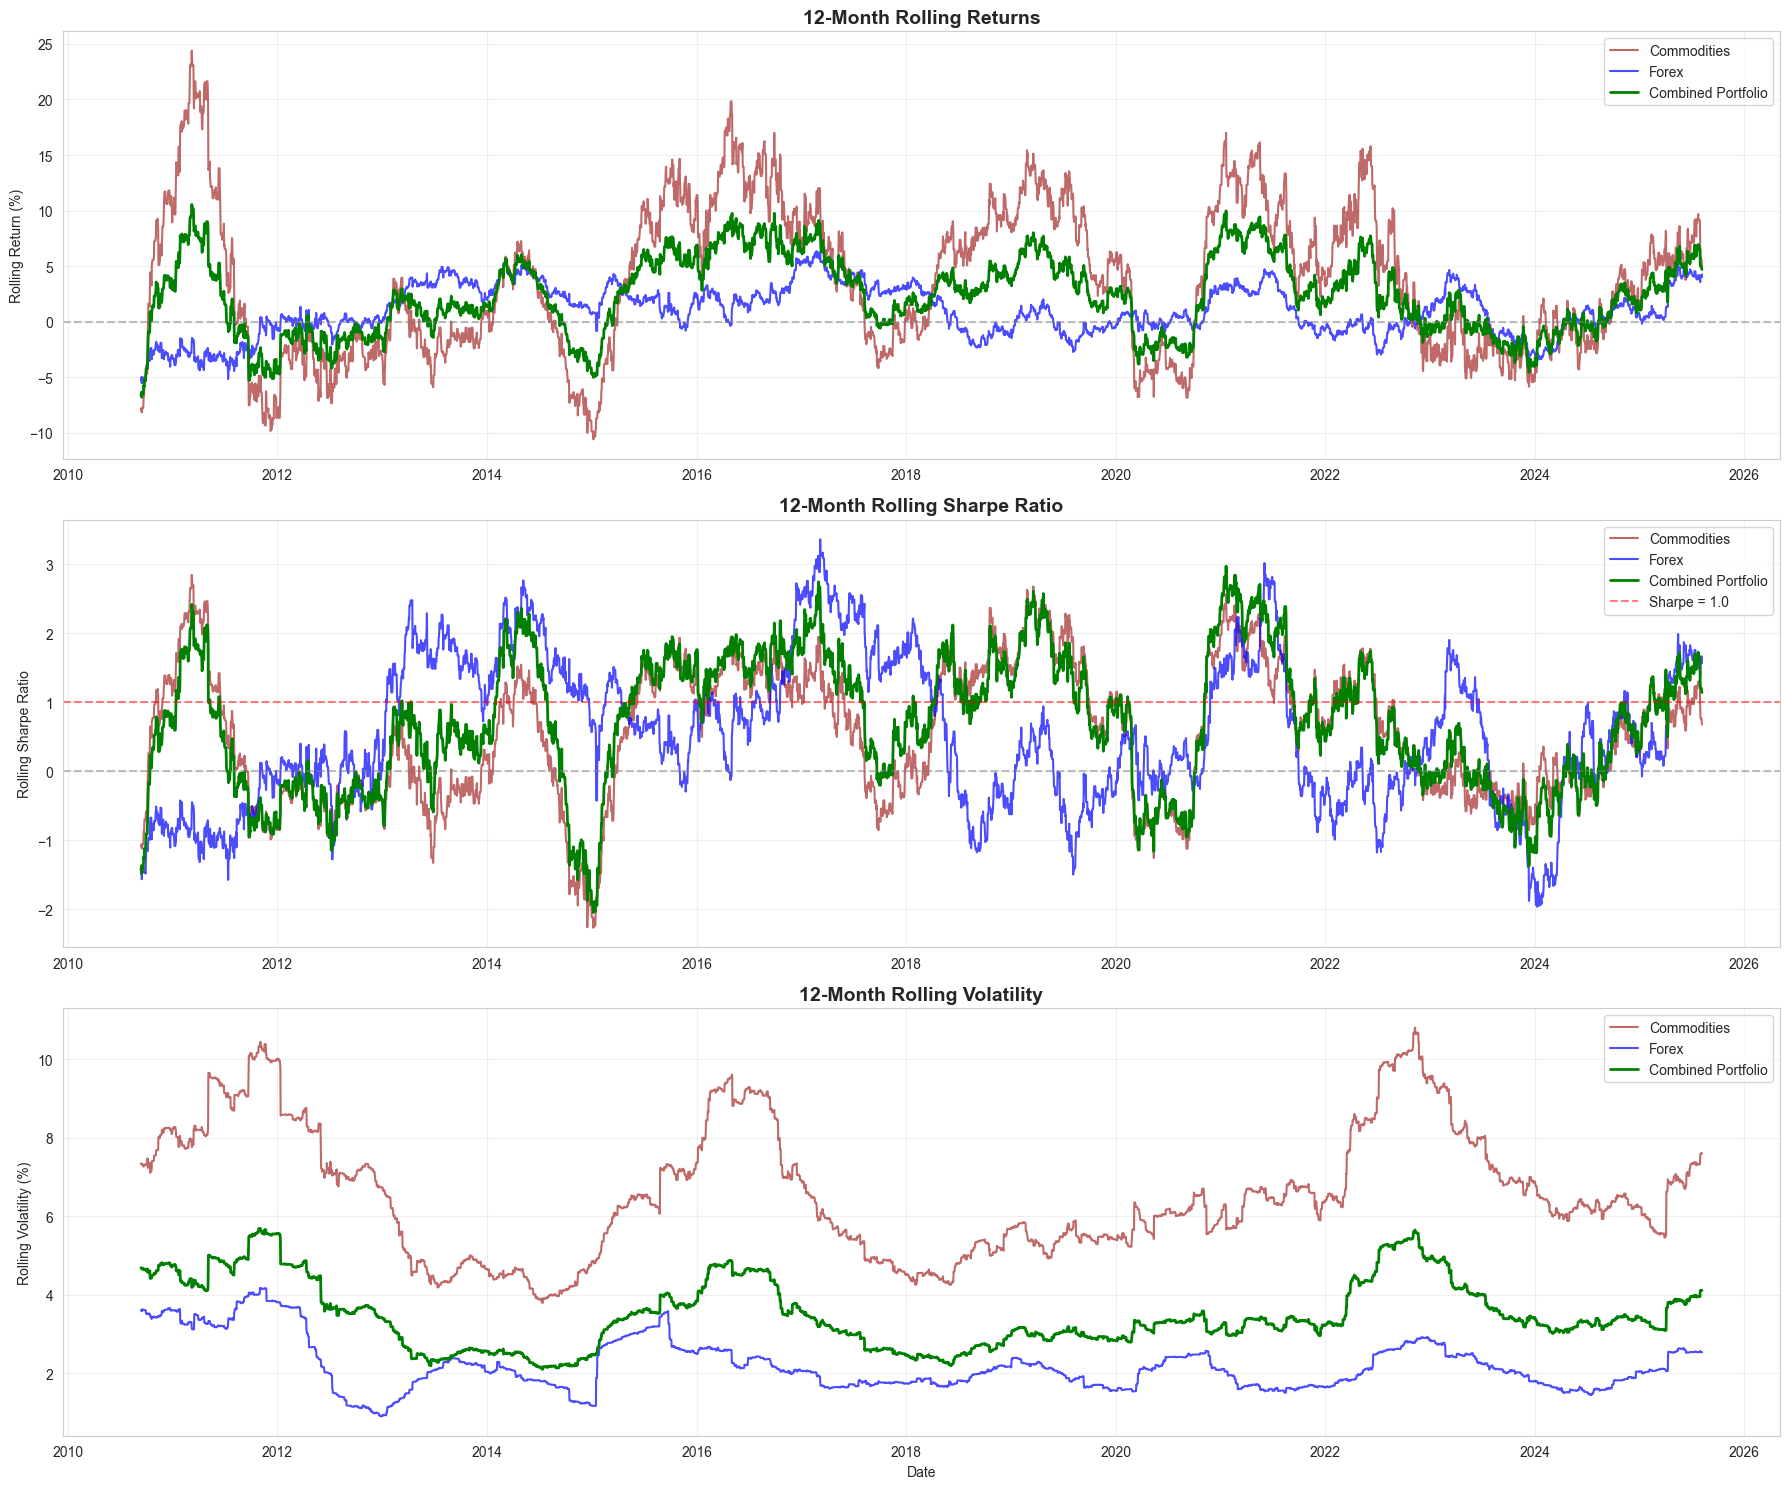


📈 ROLLING PERFORMANCE STATISTICS:
          Strategy  Avg Rolling Return  Rolling Return Std  Avg Rolling Sharpe  Rolling Sharpe Std
       Commodities               3.757               6.638               0.552               0.964
             Forex               0.994               2.239               0.543               1.054
Combined Portfolio               2.373               3.451               0.701               0.967

✅ Rolling performance analysis completed


In [6]:
def calculate_rolling_metrics(returns, equity, window=252):
    """
    Calculate rolling performance metrics
    """
    # Rolling returns (annualized)
    rolling_returns = returns.rolling(window).apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Rolling volatility (annualized)
    rolling_vol = returns.rolling(window).std() * np.sqrt(252) * 100
    
    # Rolling Sharpe ratio
    rolling_sharpe = (returns.rolling(window).mean() * 252) / (returns.rolling(window).std() * np.sqrt(252))
    
    return pd.DataFrame({
        'rolling_returns': rolling_returns,
        'rolling_volatility': rolling_vol,
        'rolling_sharpe': rolling_sharpe
    })

# Calculate rolling metrics for all strategies
print("📊 ROLLING PERFORMANCE ANALYSIS (12-Month Windows)")
print("=" * 60)

commodities_rolling = calculate_rolling_metrics(portfolio_results['commodities_returns'], 
                                              portfolio_results['commodities_equity'])
forex_rolling = calculate_rolling_metrics(portfolio_results['forex_returns'], 
                                        portfolio_results['forex_equity'])
portfolio_rolling = calculate_rolling_metrics(portfolio_results['portfolio_returns'], 
                                            portfolio_results['portfolio_equity'])

# Create rolling performance plots
fig, axes = plt.subplots(3, 1, figsize=(18, 15))

# Rolling returns
axes[0].plot(commodities_rolling.index, commodities_rolling['rolling_returns'], 
            label='Commodities', color='brown', alpha=0.7)
axes[0].plot(forex_rolling.index, forex_rolling['rolling_returns'], 
            label='Forex', color='blue', alpha=0.7)
axes[0].plot(portfolio_rolling.index, portfolio_rolling['rolling_returns'], 
            label='Combined Portfolio', color='green', linewidth=2)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('12-Month Rolling Returns', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Rolling Return (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling Sharpe ratio
axes[1].plot(commodities_rolling.index, commodities_rolling['rolling_sharpe'], 
            label='Commodities', color='brown', alpha=0.7)
axes[1].plot(forex_rolling.index, forex_rolling['rolling_sharpe'], 
            label='Forex', color='blue', alpha=0.7)
axes[1].plot(portfolio_rolling.index, portfolio_rolling['rolling_sharpe'], 
            label='Combined Portfolio', color='green', linewidth=2)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
axes[1].set_title('12-Month Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Rolling Sharpe Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Rolling volatility
axes[2].plot(commodities_rolling.index, commodities_rolling['rolling_volatility'], 
            label='Commodities', color='brown', alpha=0.7)
axes[2].plot(forex_rolling.index, forex_rolling['rolling_volatility'], 
            label='Forex', color='blue', alpha=0.7)
axes[2].plot(portfolio_rolling.index, portfolio_rolling['rolling_volatility'], 
            label='Combined Portfolio', color='green', linewidth=2)
axes[2].set_title('12-Month Rolling Volatility', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Rolling Volatility (%)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Rolling performance statistics
print("\n📈 ROLLING PERFORMANCE STATISTICS:")
rolling_stats = pd.DataFrame({
    'Strategy': ['Commodities', 'Forex', 'Combined Portfolio'],
    'Avg Rolling Return': [
        commodities_rolling['rolling_returns'].mean(),
        forex_rolling['rolling_returns'].mean(),
        portfolio_rolling['rolling_returns'].mean()
    ],
    'Rolling Return Std': [
        commodities_rolling['rolling_returns'].std(),
        forex_rolling['rolling_returns'].std(),
        portfolio_rolling['rolling_returns'].std()
    ],
    'Avg Rolling Sharpe': [
        commodities_rolling['rolling_sharpe'].mean(),
        forex_rolling['rolling_sharpe'].mean(),
        portfolio_rolling['rolling_sharpe'].mean()
    ],
    'Rolling Sharpe Std': [
        commodities_rolling['rolling_sharpe'].std(),
        forex_rolling['rolling_sharpe'].std(),
        portfolio_rolling['rolling_sharpe'].std()
    ]
})

print(rolling_stats.round(3).to_string(index=False))

print("\n✅ Rolling performance analysis completed")

## 6. Summary and Conclusions

Final summary of the multi-asset portfolio analysis:

In [7]:
print("\n" + "=" * 80)
print("MULTI-ASSET PORTFOLIO ANALYSIS - FINAL SUMMARY")
print("=" * 80)

print(f"\n🎯 PORTFOLIO COMPOSITION:")
print(f"   • Daily Equal-Weighted Rebalancing: 50% Commodities, 50% Forex")
print(f"   • Lookahead Bias Prevention: All decisions based on t-1 information")
print(f"   • Trading Period: {len(portfolio_results)} days")
print(f"   • Date Range: {portfolio_results.index.min().strftime('%Y-%m-%d')} to {portfolio_results.index.max().strftime('%Y-%m-%d')}")

print(f"\n📊 PERFORMANCE HIGHLIGHTS:")
print(f"   • Combined Portfolio Total Return: {portfolio_metrics['Total Return (%)']:.2f}%")
print(f"   • Combined Portfolio CAGR: {portfolio_metrics['CAGR (%)']:.2f}%")
print(f"   • Combined Portfolio Sharpe Ratio: {portfolio_metrics['Sharpe Ratio']:.4f}")
print(f"   • Combined Portfolio Max Drawdown: {portfolio_metrics['Max Drawdown (%)']:.2f}%")

print(f"\n🔄 DIVERSIFICATION BENEFITS:")
print(f"   • Daily Returns Correlation: {correlation:.4f}")
print(f"   • Sharpe Ratio Improvement: {sharpe_improvement:+.4f}")
print(f"   • Volatility Reduction: {vol_reduction:+.2f}%")
print(f"   • Max Drawdown Improvement: {dd_improvement:+.2f}%")

print(f"\n⚖️  INDIVIDUAL STRATEGY CONTRIBUTION:")
print(f"   • Commodities: {commodities_metrics['Total Return (%)']:.2f}% total return, {commodities_metrics['Sharpe Ratio']:.4f} Sharpe")
print(f"   • Forex: {forex_metrics['Total Return (%)']:.2f}% total return, {forex_metrics['Sharpe Ratio']:.4f} Sharpe")
print(f"   • Combined: {portfolio_metrics['Total Return (%)']:.2f}% total return, {portfolio_metrics['Sharpe Ratio']:.4f} Sharpe")

print(f"\n🎯 KEY INSIGHTS:")

if portfolio_sharpe > max(commodities_sharpe, forex_sharpe):
    print(f"   • ✅ Diversification successful: Portfolio Sharpe exceeds both individual strategies")
else:
    print(f"   • ⚠️  Limited diversification benefit: Consider strategy selection or weighting")

if abs(correlation) < 0.5:
    print(f"   • ✅ Low correlation ({correlation:.3f}) provides good diversification potential")
elif abs(correlation) < 0.8:
    print(f"   • ⚠️  Moderate correlation ({correlation:.3f}) provides some diversification")
else:
    print(f"   • ❌ High correlation ({correlation:.3f}) limits diversification benefits")

if vol_reduction > 0:
    print(f"   • ✅ Volatility reduction achieved through diversification ({vol_reduction:.2f}% lower)")
else:
    print(f"   • ⚠️  No volatility reduction from diversification")

if dd_improvement > 0:
    print(f"   • ✅ Maximum drawdown improved through diversification ({dd_improvement:.2f}% better)")
else:
    print(f"   • ⚠️  No drawdown improvement from diversification")

print(f"\n🚀 IMPLEMENTATION RECOMMENDATIONS:")
print(f"   • Daily rebalancing frequency appears appropriate for this strategy combination")
print(f"   • Consider transaction cost analysis for practical implementation")
print(f"   • Monitor correlation stability over time for regime changes")
print(f"   • Evaluate risk-adjusted performance vs individual strategy allocation")

if sharpe_improvement > 0.1:
    print(f"   • Strong recommendation: Combined portfolio significantly outperforms individual strategies")
elif sharpe_improvement > 0:
    print(f"   • Moderate recommendation: Combined portfolio shows modest improvement")
else:
    print(f"   • Caution: Consider alternative combination or individual strategy selection")

print(f"\n✨ PORTFOLIO CHARACTERISTICS:")
print(f"   • Risk-adjusted performance: {'Excellent' if portfolio_sharpe > 1.0 else 'Good' if portfolio_sharpe > 0.5 else 'Moderate'}")
print(f"   • Consistency: {'High' if portfolio_rolling['rolling_sharpe'].std() < 0.5 else 'Moderate'}")
print(f"   • Diversification effectiveness: {'High' if sharpe_improvement > 0.1 else 'Moderate' if sharpe_improvement > 0 else 'Low'}")

print("\n" + "=" * 80)
print("MULTI-ASSET PORTFOLIO ANALYSIS COMPLETED")
print("=" * 80)

# Save results for future analysis
try:
    output_path = Path('./multi_asset_portfolio_results.parquet')
    portfolio_results.to_parquet(output_path)
    print(f"\n💾 Results saved to: {output_path}")
except Exception as e:
    print(f"\n❌ Could not save results: {e}")

print("\n🎉 Analysis complete! The combined portfolio demonstrates the benefits of daily rebalancing between optimized commodities and forex contrarian strategies.")


MULTI-ASSET PORTFOLIO ANALYSIS - FINAL SUMMARY

🎯 PORTFOLIO COMPOSITION:
   • Daily Equal-Weighted Rebalancing: 50% Commodities, 50% Forex
   • Lookahead Bias Prevention: All decisions based on t-1 information
   • Trading Period: 5694 days
   • Date Range: 2010-01-04 to 2025-08-06

📊 PERFORMANCE HIGHLIGHTS:
   • Combined Portfolio Total Return: 59.35%
   • Combined Portfolio CAGR: 2.08%
   • Combined Portfolio Sharpe Ratio: 0.5845
   • Combined Portfolio Max Drawdown: -9.04%

🔄 DIVERSIFICATION BENEFITS:
   • Daily Returns Correlation: 0.0290
   • Sharpe Ratio Improvement: +0.0958
   • Volatility Reduction: +0.94%
   • Max Drawdown Improvement: +9.42%

⚖️  INDIVIDUAL STRATEGY CONTRIBUTION:
   • Commodities: 101.73% total return, 0.4888 Sharpe
   • Forex: 22.28% total return, 0.3938 Sharpe
   • Combined: 59.35% total return, 0.5845 Sharpe

🎯 KEY INSIGHTS:
   • ✅ Diversification successful: Portfolio Sharpe exceeds both individual strategies
   • ✅ Low correlation (0.029) provides good 